# CNN - Example 03

In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense

## Load Tensorflow Dataset (tfds)

In [2]:
# Import TensorFlow Datasets
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [3]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

### Get train/test dataset

In [4]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)

In [5]:
train_dataset, test_dataset = dataset['train'], dataset['test']

In [6]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']

In [7]:
def getName(id):
    return class_names[id]

In [8]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples:     {}".format(num_test_examples))

Number of training examples: 60000
Number of test examples:     10000


In [10]:
tfds.as_dataframe(train_dataset.take(5), metadata)

,image,label
0,,2 (Pullover)
1,,1 (Trouser)
2,,8 (Bag)
3,,4 (Coat)
4,,1 (Trouser)


### Normalize

In [9]:
## Preprocess the data

#The value of each pixel in the image data is an integer in the range `[0,255]`. 
#For the model to work properly, these values need to be normalized to the range `[0,1]`. 
#So here we create a normalization function, and then apply it to each image in the test and train datasets.

In [10]:
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

# The map function applies the normalize function to each element in the train
# and test datasets
train_dataset =  train_dataset.map(normalize)
test_dataset  =  test_dataset.map(normalize)

In [11]:
# The first time you use the dataset, the images will be loaded from disk
# Caching will keep them in memory, making training faster
train_dataset =  train_dataset.cache()
test_dataset  =  test_dataset.cache()

### Explore the data

Coat


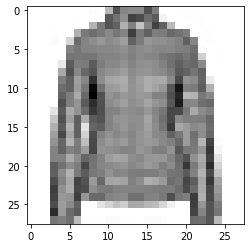

In [12]:
# Take a single image, and remove the color dimension by reshaping
for image, label in test_dataset.take(1):
  break
image = image.numpy().reshape((28,28))
plt.imshow(image, cmap=plt.cm.binary)
print(getName(label))

Display the first 25 images from the *training set* and display the class name below each image. Verify that the data is in the correct format and we're ready to build and train the network.

### Display few images

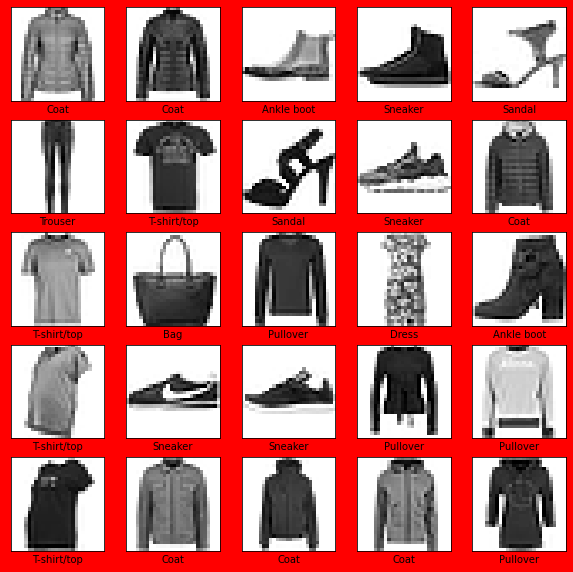

In [13]:
plt.figure(figsize=(10,10),facecolor="red")
i = 0
for (image, label) in test_dataset.take(25):
    image = image.numpy().reshape((28,28))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(class_names[label])
    i += 1
plt.show()

## Model # 1

In [14]:
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', activation=tf.nn.relu, input_shape=(28, 28, 1)))
model.add(MaxPooling2D((2,2), strides=2))
model.add(Conv2D(64, (3,3), padding='same', activation=tf.nn.relu))
model.add(MaxPooling2D((2,2),strides=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               401536    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1

In [16]:
#Loss function — An algorithm for measuring how far the model's outputs are from the desired output. The goal of training is this measures loss.
#Optimizer —An algorithm for adjusting the inner parameters of the model in order to minimize loss.
#Metrics —Used to monitor the training and testing steps. The following example uses accuracy, the fraction of the images that are correctly classified.

In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

### Train the model

First, we define the iteration behavior for the train dataset:
1. Repeat forever by specifying `dataset.repeat()`
2. The `dataset.shuffle(60000)` randomizes the order so our model cannot learn anything from the order of the examples.
3. And `dataset.batch(32)` tells `model.fit` to use batches of 32 images and labels when updating the model variables.
4. The `epochs=5` parameter limits training to 5 full iterations of the training dataset, so a total of 5 * 60000 = 300000 examples.

(Don't worry about `steps_per_epoch`, the requirement to have this flag will soon be removed.)

#### Shuffle train set + batch

In [18]:
BATCH_SIZE = 32
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

In [19]:
history = model.fit(train_dataset, epochs=10, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/10
1875/1875 [==============================] - 51s 27ms/step - loss: 0.4056 - accuracy: 0.8550
Epoch 2/10
1875/1875 [==============================] - 56s 30ms/step - loss: 0.2691 - accuracy: 0.9031
Epoch 3/10
 572/1875 [========>.....................] - ETA: 38s - loss: 0.2281 - accuracy: 0.9173

KeyboardInterrupt: 

### Evaluate

#### Eval - Train

In [ ]:
model.metrics_names

In [ ]:
pd.DataFrame(history.history).head(10)

In [ ]:
pd.DataFrame(history.history).plot()

In [ ]:
losses = pd.DataFrame(history.history)

In [ ]:
losses

In [ ]:
losses[['loss','accuracy']].plot()

#### Eval - Test

In [ ]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))

In [ ]:
print('Loss on test dataset:', test_loss)
print('Accuracy on test dataset:', test_accuracy)

In [ ]:
# As it turns out, the accuracy on the test dataset is smaller than the accuracy on the training dataset. 
# This is completely normal, since the model was trained on the `train_dataset`. 
# When the model sees images it has never seen during training, (that is, from the `test_dataset`), 
# we can expect performance to go down. 

In [ ]:
print("Loss and Accuracy on Train dataset:")

In [ ]:
pd.DataFrame(history.history).tail()

### Predictions

In [ ]:
len(test_dataset)/BATCH_SIZE

In [ ]:
for test_images, test_labels in test_dataset.take(1):
  x_test = test_images.numpy()
  y_test = test_labels.numpy()

In [ ]:
y_prediction =  np.argmax(model.predict(x_test), axis=-1)

In [ ]:
len(y_test)

In [ ]:
len(y_prediction)

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test, y_prediction))
print(confusion_matrix(y_test, y_prediction))

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(confusion_matrix(y_test,y_prediction),annot=True)

### Predictions go wrong!

In [ ]:
# Show some misclassified examples
misclassified_idx = np.where(y_prediction != y_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i].reshape(28,28), cmap='gray')
#plt.title("True label: %s Predicted: %s" % (y_test[i], y_prediction[i]));
t = getName(y_test[i])
p = getName(y_prediction[i])
plt.title("True label: %s Predicted: %s" % (t, p));

In [ ]:
print("Percentage of wrong predcitions : " + str(len(misclassified_idx)/len(y_prediction)*100) + " %")
print("Models maximum accuracy            : " + str(np.max(history.history['accuracy'])*100) + " %")
#print("Models maximum validation accuracy : " + str(np.max(history.history['val_accuracy'])*100) + " %")

### Additonal Files(s) to test the model

In [ ]:
# Grab an image from the test dataset
img = test_images[0]

print(img.shape)

img = np.array([img])

print(img.shape)

predictions_single = model.predict(img)

print(predictions_single)

np.argmax(predictions_single[0])

### Exercises

Experiment with different models and see how the accuracy results differ. In particular change the following parameters:
*   Set training epochs set to 1
*   Number of neurons in the Dense layer following the Flatten one. For example, go really low (e.g. 10) in ranges up to 512 and see how accuracy changes
*   Add additional Dense layers between the Flatten and the final Dense(10), experiment with different units in these layers
*   Don't normalize the pixel values, and see the effect that has


Remember to enable GPU to make everything run faster (Runtime -> Change runtime type -> Hardware accelerator -> GPU).
Also, if you run into trouble, simply reset the entire environment and start from the beginning:
*   Edit -> Clear all outputs
*   Runtime -> Reset all runtimes